In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Creation of the dataset

In [3]:
n=5        #polinomial degree
N=25      #number of samples

In [4]:
vander = lambda x, n : np.vander(x, n+1,True)

In [5]:
x=np.random.uniform(-1,1,size=N)          # sampled x
X=vander(x,n)
w_t=np.random.normal(size=n+1)         # real underlying weights
y=X@w_t
y_=y+np.random.normal(scale=0.5,size=N)   # sampled y with noise

Let's define the GD method with backtracking

In [6]:
def SGDm(f, grad_f, w0, data, batch_size, epochs, alpha=0.001, momentum=0.9):
    
    import numpy as np
    import math

    X=data[0]
    Y=data[1]

    if len(X.shape)==1:
        X=np.expand_dims(X,0)

    if len(Y.shape)==1:
        Y=np.expand_dims(Y,0)

    data=np.concatenate([X, Y],0)

    data=data.T     #easier to maniputlate batch first

    l=len(data)
    s=X.shape[0]

    n_batch=math.ceil(l/batch_size)
    tot_batch=epochs*n_batch
    
    w = np.empty((tot_batch+1,)+w0.shape)
    f_val = np.empty(tot_batch)
    grads = np.empty((tot_batch,)+w0.shape)
    err = np.empty(tot_batch)
    
    w[0]=w0
    k=0

    G= np.zeros(w0.shape)

    m=momentum

    mt=1

    for e in range(epochs):

        np.random.shuffle(data)
        

        for b in range(n_batch):

            data_b=data[b*batch_size:min((b+1)*batch_size,l)].T      # take a batch of data

            X_b=data_b[:s]
            Y_b=data_b[s:]

            f_val[k]=f( w[k], (X_b,Y_b) )
            grads[k]=grad_f( w[k], (X_b,Y_b) )
            err[k] = grads[k].T@grads[k]

            G = m*G + (1-m)*grads[k]
            mt*=m
            w[k+1]=w[k]-alpha*G/(1+mt)

            k+=1
            
    return w[1:], k, f_val, grads, err

# MLE

We try to maximize the likelihood $p(D|w)$

so we minimize $-log(p(D|w))$

$w=\underset{w}{argmin} \sum_{i=1}^{N}{-log\,p((x_i,y_i)|w)}$

$=\underset{w}{argmin} \sum_{i=1}^{N}-log(\frac{1}{ \sigma \sqrt{2 \pi}} e^{-\frac{1}{2\sigma ^2}(w_0 + w_1x_i + · · · + w_nx_i^n − yi)^2})$

$=\underset{w}{argmin} \sum_{i=1}^{N}{(w_0 + w_1x_i + · · · + w_nx_i^n − yi)^2}$

therefore we define

$f=\frac{1}{2}||Xw − y||^2$

$\nabla f=(Xw − y)^TX$


In [7]:
def f(w,D):
    x=D[0]
    Y=D[1]
    X=vander(np.squeeze(x),w.size-1)
    return np.power(np.linalg.norm(X@w-Y),2) /Y.size

def grad_f(w,D):
    x=D[0]
    Y=D[1]
    X=vander(np.squeeze(x),w.size-1)
    return 2*(X@w-Y)@X /Y.size

In [8]:
W1=[]
F1=[]

degrees=[1,2,3,4,5,6]

b_s=100
epochs=10000
data=(x,y_)



for i in degrees:
    w0=np.random.uniform(min(x),max(x),i+1)
    w1, k, f_val, grads, err=SGDm(f, grad_f, w0, data, b_s, epochs, alpha=0.1, momentum=0.0)
    W1.append(w1)
    F1.append(f_val)

Text(0.5, 0, 'epochs')

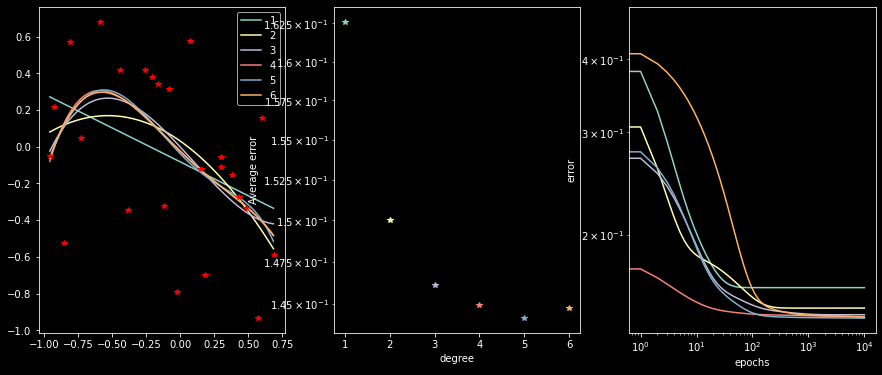

In [9]:
plt.figure(figsize=(15, 6 ))

t=np.arange(min(x),max(x),0.001)

V=vander(t,n)
y=V@w_t
plt.plot(t,y)

plt1=plt.subplot(1,3,1)
plt2=plt.subplot(1,3,2)
plt3=plt.subplot(1,3,3)

for i in range(len(degrees)):

    V=vander(t,degrees[i])
    yi=V@W1[i][-1]
    plt1.plot(t,yi)

    e=np.mean(F1[i][-10:])
    plt2.plot(degrees[i],e,'*')

    plt3.plot(F1[i])

plt1.plot(x,y_,'r*')
plt1.legend(degrees)

plt2.set_yscale('log')
plt2.set_ylabel('Average error')
plt2.set_xlabel('degree')

plt3.set_yscale('log')
plt3.set_xscale('log')
plt3.set_ylabel('error')
plt3.set_xlabel('epochs')

# MAP

We try to maximize the posterior probability

$p(w|D)=\frac{p(D|w)p(w)}{p(D)}$

so we minimize $-log(p(w|D))$

and w becomes:


$w=\underset{w}{argmin} \sum_{i=1}^{N}{-log\,p((x_i,y_i)|w)-log\,p(w)}$

$=\underset{w}{argmin} \sum_{i=1}^{N}-log(\frac{1}{ \sigma_x \sqrt{2 \pi}} e^{-\frac{1}{2\sigma_x ^2}(w_0 + w_1x_i + · · · + w_nx_i^n − yi)^2})
-log(\frac{1}{ \sigma_w \sqrt{2 \pi}} e^{-\frac{1}{2\sigma_w ^2}(w)^2})$

$=\underset{w}{argmin} \sum_{i=1}^{N}{\frac{1}{2\sigma_x ^2}(w_0 + w_1x_i + · · · + w_nx_i^n − yi)^2}
+\frac{1}{2\sigma_w ^2}(w)^2$

defining $\lambda = \frac{\sigma_x}{\sigma_w}$

it's equivalent to

$=\underset{w}{argmin}\;||Xw-y||^2
+\lambda|w|^2$

where $\lambda$ is the corrisponding of the normalization factor in Empirical Risk Minimization

therefore we define

$f=\frac{1}{2}||Xw-y||^2+\frac{\lambda}{2}|w|^2$

$\nabla f=(Xw − y)^TX+\lambda(w)^T$

In [10]:
def f2(w,D,l):
    x=D[0]
    Y=D[1]
    X=vander(np.squeeze(x),w.size-1)
    return np.power(np.linalg.norm(X@w-Y),2)/2/Y.size+l*np.power(np.linalg.norm(w),2)/2

def grad_f2(w,D,l):
    x=D[0]
    Y=D[1]
    X=vander(np.squeeze(x),w.size-1)
    return 2*(X@w-Y)@X/Y.size+l*w       

In [11]:
W2=[]
F2=[]

degrees=[1,2,3,4,5]

b_s=100
epochs=10000
data=(x,y_)

l=0.1

f=lambda w,D:f2(w,D,l)
grad_f=lambda w,D:grad_f2(w,D,l)

for i in degrees:
    w0=np.random.uniform(min(x),max(x),i+1)
    w2, k, f_val, grads, err=SGDm(f, grad_f, w0, data, b_s, epochs, alpha=0.1, momentum=0.0)
    W2.append(w2)
    F2.append(f_val)

Text(0.5, 0, 'epochs')

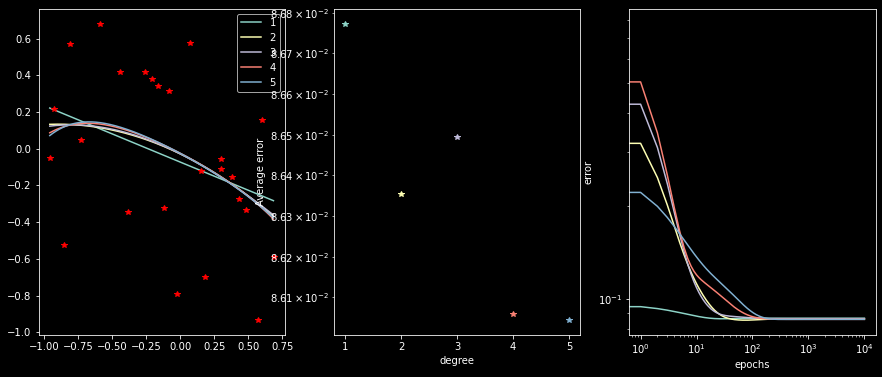

In [12]:
plt.figure(figsize=(15, 6 ))

t=np.arange(min(x),max(x),0.001)

V=vander(t,n)
y=V@w_t
plt.plot(t,y)

plt1=plt.subplot(1,3,1)
plt2=plt.subplot(1,3,2)
plt3=plt.subplot(1,3,3)

for i in range(len(degrees)):

    V=vander(t,degrees[i])
    yi=V@W2[i][-1]
    plt1.plot(t,yi)

    e=np.mean(F2[i][-10:])
    plt2.plot(degrees[i],e,'*')

    plt3.plot(F2[i])

plt1.plot(x,y_,'r*')
plt1.legend(degrees)

plt2.set_yscale('log')
plt2.set_ylabel('Average error')
plt2.set_xlabel('degree')

plt3.set_yscale('log')
plt3.set_xscale('log')
plt3.set_ylabel('error')
plt3.set_xlabel('epochs')

# MLE vs MAP

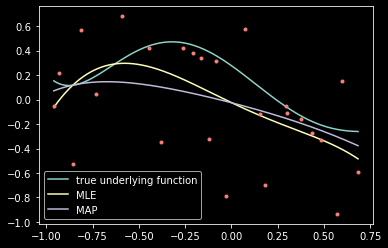

In [13]:
t=np.arange(min(x),max(x),0.001)

y=vander(t,n)@w_t
y1=vander(t,w1[-1].size-1)@w1[-1]
y2=vander(t,w2[-1].size-1)@w2[-1]
#np.polyval() si aspetta l'ordine dei parametri invertito

plt.plot(t,y)
plt.plot(t,y1)
plt.plot(t,y2)
plt.plot(x,y_,'.')

plt.legend(['true underlying function','MLE','MAP'])


Since the problem is very ill conditioned it takes way too long to completely converge, making it very difficult to really appreciate the importance od the normalization. On the other hand, since optimizing the MLE and MAP with a gaussian distribution is a convex optimization problem, we know that it has a single mimimum, that we can obtain with the normal equations. This minimum is exactly the same minimum we would get with GD given enoght time to converge.

For these reasons, to understand what is the effect of the normalization we are going to calculate the limit analitically.

<br>

for MLE we have

$\nabla f=(Xw − y)^TX$

and setting it to 0 we obtain

$w=(W^TW)^{-1}W^Ty$

<br>

for MAP we have

$\nabla f=(Xw − y)^TX+\lambda(w)^T$

and setting it to 0 we obtain

$w=(W^TW+\lambda\mathbb{I})^{-1}W^Ty$

<br>

We are goint to plot the MLE and MAP approximating the data with polinomlial of different degrees. The underlying degree is set to 5.

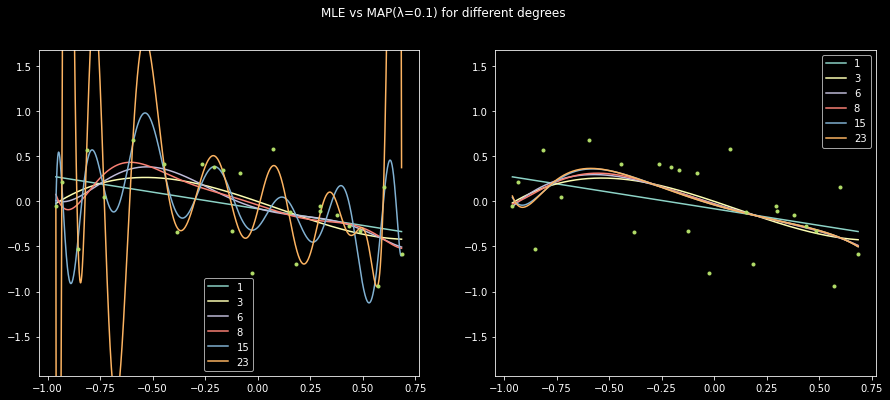

In [14]:
degrees=[1,3,6,8,15,23]

x=data[0]
y_=data[1]

t=np.arange(min(x),max(x),0.001)

plt.figure(figsize=(15, 6 ))
p1=plt.subplot(1,2,1)
p2=plt.subplot(1,2,2)
plt.suptitle('MLE vs MAP(λ=0.1) for different polinomial degrees')

for d in degrees:
    X=np.vander(x,d+1)
    
    w1=np.linalg.solve(X.T@X,X.T@y_)
    y1=np.vander(t,d+1)@w1
    p1.plot(t,y1)

    w2=np.linalg.solve(X.T@X+0.01*np.eye(d+1),X.T@y_)
    y2=np.vander(t,d+1)@w2
    p2.plot(t,y2)

p1.plot(x,y_,'.')
p1.set_ylim(min(y_)-1,max(y_)+1)
p1.legend(degrees)

p2.plot(x,y_,'.')
p2.set_ylim(min(y_)-1,max(y_)+1)
p2.legend(degrees)

As we can see in the MLE estimations when the polinome we are using has a degre greater than original underlying one the functions starts to fit the noise causing big oscillations.

On the other hand adding the priors for the weights greatly reduces this behaviour.

Let's now fix the degree for the approximation and see the effect of the factor $\lambda$

Text(0.5, 1.0, 'MAP for different λ')

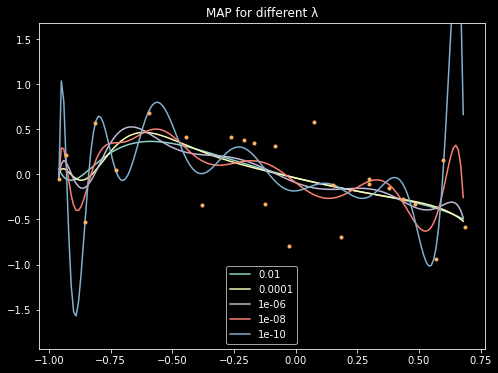

In [19]:
lamb=[1e-2,1e-4,1e-6,1e-8,1e-10]

d=23

x=data[0]
y_=data[1]

t=np.arange(min(x),max(x),0.01)

plt.figure(figsize=(8, 6 ))

for l in lamb:
    X=np.vander(x,d+1)
    
    w2=np.linalg.solve(X.T@X+l*np.eye(d+1),X.T@y_)
    y2=np.vander(t,d+1)@w2
    plt.plot(t,y2)

plt.plot(x,y_,'.')
plt.ylim(min(y_)-1,max(y_)+1)
plt.legend(lamb)
plt.title('MAP for different λ')

The greater $\lambda$ the more it dumpens the oscillations.

It should also be said that this effect is much more evident the less data we have.

Let's plot the MLE for the polinomial of degree 23

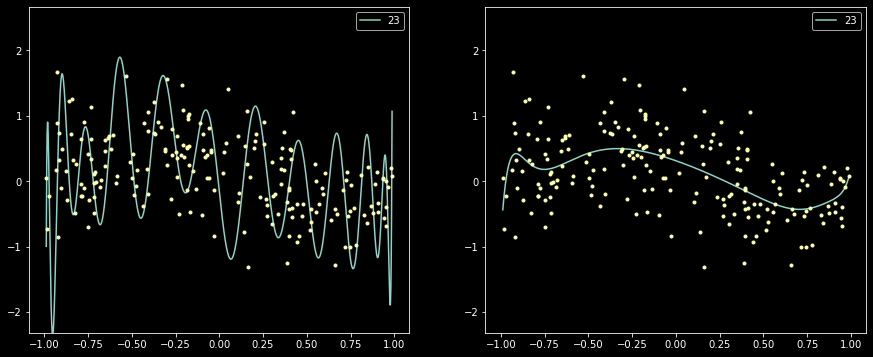

In [16]:
degrees=[23]

N=200

x=np.random.uniform(-1,1,size=N)          # sampled x
X=vander(x,n)
y=X@w_t
y_=y+np.random.normal(scale=0.5,size=N)   # sampled y with noise

t=np.arange(min(x),max(x),0.001)

plt.figure(figsize=(15, 6 ))
p1=plt.subplot(1,2,1)
p2=plt.subplot(1,2,2)

for d in degrees:
    X=np.vander(x,d+1)
    
    w1=np.linalg.solve(X.T@X,X.T@y_)
    y1=np.vander(t,d+1)@w1
    p1.plot(t,y1)

    w2=np.linalg.solve(X.T@X+0.01*np.eye(d+1),X.T@y_)
    y2=np.vander(t,d+1)@w2
    p2.plot(t,y2)

p1.plot(x,y_,'.')
p1.set_ylim(min(y_)-1,max(y_)+1)
p1.legend(degrees)

p2.plot(x,y_,'.')
p2.set_ylim(min(y_)-1,max(y_)+1)
p2.legend(degrees)

Still, the MAP estimate is way smoother

# MONTE CARLO INTEGRATION

- Plot a circle of radius $r = 0.5$, enclosed by a square with dimensions $l = 1$.
    Generate a large number $N_{total}$ of uniformly distributed random points and plot them. These points
    can be in any position within the square. If they fall within the circle, plot them as red points, otherwise colour them as blue points.
    Define the variable $g = \frac{l^2}{r^2}\frac{N_{inter}}{N_{total}}$
    , where $N_{inter}$ is the number of points within the circle, Ntotal is the
    total number of points.
    For increasing values $N_{total}$, which is the famous mathematical constant approximated by g? Compare
    them varying the number of $N_{total}$.

g = 3.148


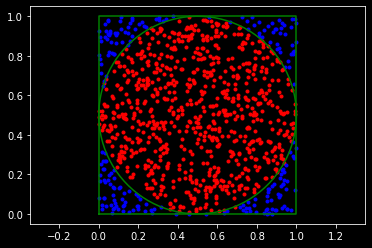

In [36]:
N_total=1000
l=1
r=l/2
c=np.array([[r],[r]])

p=np.random.rand(2,N_total)*l
d=np.linalg.norm(c-p,axis=0)
int=sum(d<r)

g=l**2*int/(r**2)/N_total

plt.plot(p[0][d<r],p[1][d<r],'.r')
plt.plot(p[0][d>=r],p[1][d>=r],'.b')

theta=np.linspace(0,2*np.math.pi,100)
plt.plot(r+r*np.cos(theta),r+r*np.sin(theta),'g')
plt.plot([0,l,l,0,0],[0,0,l,l,0],'g')
plt.axis('equal')

print(f"g = {g}")

The constant is approximating $\pi$.

The sum of random sampled points inside the circle is an approximation of the area of the circle